# Introduction



Our project explores the question: what is the best neighborhood in Pittsburgh? 
To answer this, we took a data-driven approach using datasets from the Western Pennsylvania Regional Data Center (WPRDC), with each team member focusing on a different submetric that could contribute to an overall definition of “bestness.”
While we decided on social services as our metric, some of the other metrics we considered were: crime rates, economic prosperity and education 


# Metric


The metric we are using to determine “bestness” is the amount of public services available in each neighborhood. 
A public service, as defined by Merriam Webster Dictionary, is the business of supplying a commodity or service to any or all members of a community. Public services include, but are not limited to, education, healthcare, food services, senior citizen services, and museums. 
The public services we are examining are schools, social services, and city parks. We chose datasets that were relevant and we felt that these are essential things that we would look for in a neighborhood. 

Initially, we were going to add the counts for each submetric to determine the best neighborhood in Pittsburgh. However, we realized that this does not account for the size of the neighborhood. It is possible that a neighborhood could support a large population and have a single school, while a smaller neighborhood has a single school as well. While the count is the same, the access to the resource varies - the larger neighborhood is less ideal because there is a single school for a larger population. In order to account for this, we decided to assign a score by dividing the count of services per neighborhood by its population and we normalized the score using a z-distribution so that we could make a fairer comparison. 



# Submetric 1: Schools


We chose Public Schools as one of the relevant datasets because schools and literacy rates generally reflect positively in a community. Additionally, they provide services that address basic needs for the community such as nutrition, healthcare and mental health support and therefore can be considered as a social service


In [1]:
import pandas as pd
import fpsnippets
from shapely.geometry import Point
import geopandas
schools_df = pd.read_csv('/ihome/cmpinf0010_2025s/kkr33/CMPINF0010-Final/Allegheny_County_Public_Schools___Local_Education_Agency_(LEAs)_Locations.csv')

NEIGHBORHOODS = geopandas.read_file(
    "https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/c5a93a8e-03d7-4eb3-91a8-c6b7db0fa261/download/pittsburghpaneighborhoods-.zip"
)
NEIGHBORHOODS = NEIGHBORHOODS.to_crs(epsg=4326)

ModuleNotFoundError: No module named 'fpsnippets'

In [ ]:
def geo_to_neighborhood(latitude, longitude):
    pt = Point(longitude, latitude)
    for _idx, neighborhood in NEIGHBORHOODS.iterrows():
        if neighborhood["geometry"].contains(pt):
            return neighborhood["hood"]
    return None
schools_df["Neighborhood"] = schools_df.apply(
lambda row: geo_to_neighborhood(row["Y"], row["X"]),
axis=1
)
school_counts = schools_df["Neighborhood"].value_counts().reset_index()
school_counts.columns = ["Neighborhood", "School Count"]


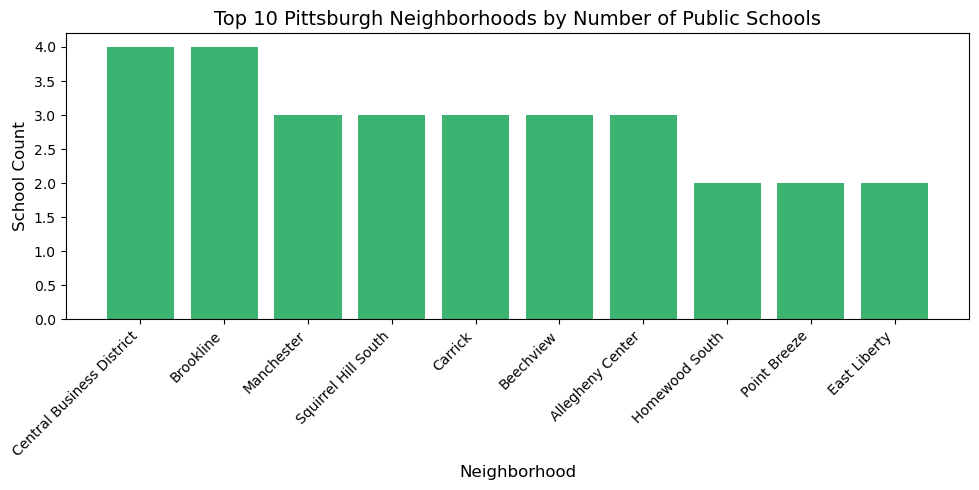

In [ ]:
import matplotlib.pyplot as plt

top10 = school_counts.sort_values(by="School Count", ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.bar(top10["Neighborhood"], top10["School Count"], color="mediumseagreen")
plt.title("Top 10 Pittsburgh Neighborhoods by Number of Public Schools", fontsize=14)
plt.xlabel("Neighborhood", fontsize=12)
plt.ylabel("School Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The graph above shows the counts of public schools per neighborhood. This is what we initially wanted to use for our data driven argument, after which we decided to change it and make it a score by dividing the count by the population of the neighborhood and normalizing that value to get a score. 

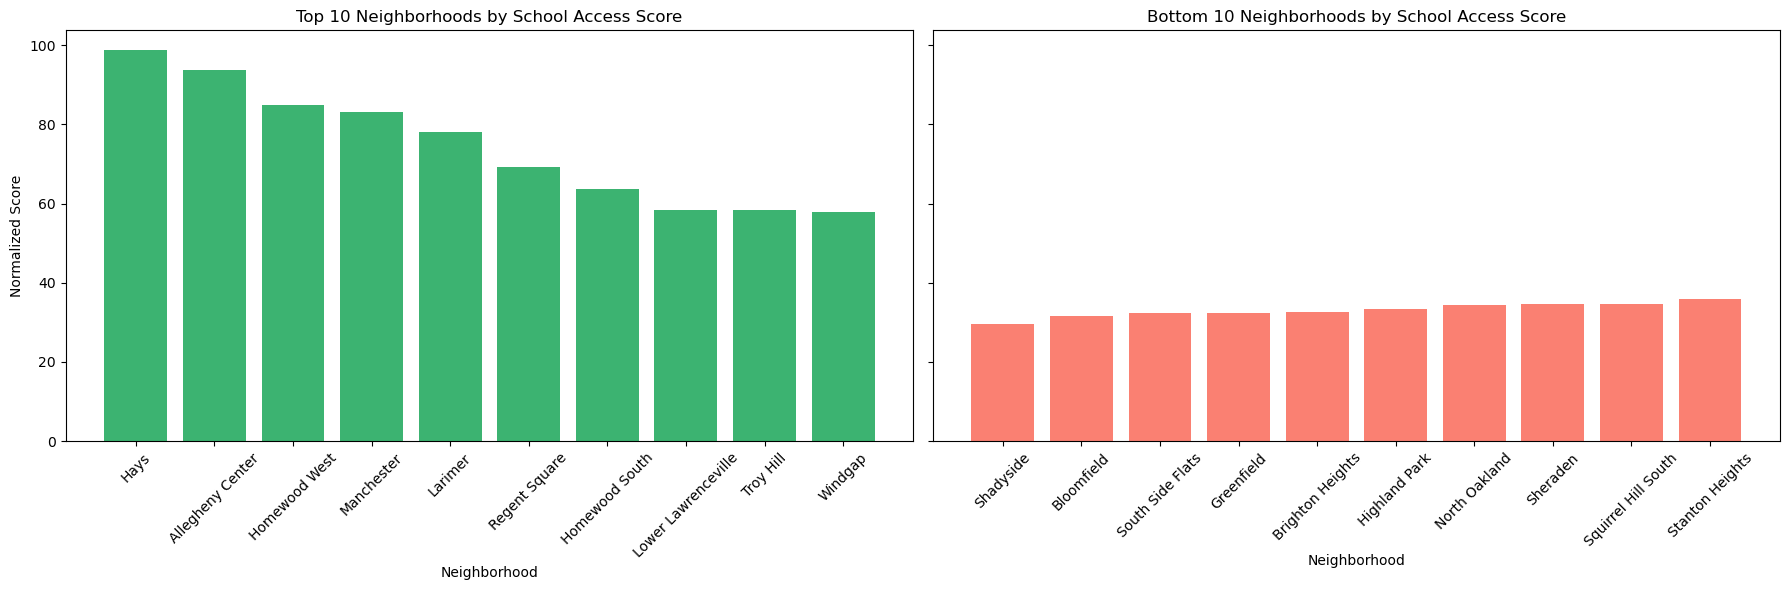

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

population_df = pd.read_csv(
    "https://data.wprdc.org/dataset/95af9f2c-61c8-446b-ae72-852e195684f3/resource/a8414ed5-c50f-417e-bb67-82b734660da6/download/preliminarycitypittsburghneighborhood_pl94171summary-2.csv"
)
population_df = population_df[["Neighborhood", "2020_Total_Population"]]
population_df["2020_Total_Population"] = pd.to_numeric(population_df["2020_Total_Population"], errors="coerce")

def clean_neighborhood_name(name):
    name = re.split(r'[-()]', name)[0]
    return name.strip()

population_df["Neighborhood"] = population_df["Neighborhood"].apply(clean_neighborhood_name)
merged_df = school_counts.copy()
merged_df["Neighborhood"] = merged_df["Neighborhood"].apply(clean_neighborhood_name)

merged_df = merged_df.merge(population_df, on="Neighborhood", how="left")
merged_df["Raw Score"] = merged_df["School Count"] / merged_df["2020_Total_Population"]
mean = merged_df["Raw Score"].mean()
std = merged_df["Raw Score"].std()
merged_df["z_score"] = (merged_df["Raw Score"] - mean) / std
merged_df["Normalized Score"] = 100 / (1 + np.exp(-merged_df["z_score"]))

top10 = merged_df.sort_values("Normalized Score", ascending=False).head(10)
bottom10 = merged_df.sort_values("Normalized Score", ascending=True).head(10)

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
axes[0].bar(top10["Neighborhood"], top10["Normalized Score"], color='mediumseagreen')
axes[0].set_title("Top 10 Neighborhoods by School Access Score")
axes[0].set_xlabel("Neighborhood")
axes[0].set_ylabel("Normalized Score")
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(bottom10["Neighborhood"], bottom10["Normalized Score"], color='salmon')
axes[1].set_title("Bottom 10 Neighborhoods by School Access Score")
axes[1].set_xlabel("Neighborhood")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


The graphs above represent the top 10 Pittsburgh neighborhoods based on our scores and the bottom 10 Pittsburgh neighborhoods respectively. 

# Social Services

The submetric that is being measured is the number of social services in a neighborhood. In this analysis, I used the BigBurgh Social Services Listing dataset and the City of Pittsburgh Neighborhood Population 2020 dataset. I measured the number of social services in each neighborhood, then divided it by the population of the neighborhood. A good neighborhood should have enough social services to support its population. Doing this also serves to balance out the rankings since more often than not, larger neighborhoods will have more services than smaller neighborhoods.

In [ ]:
import pandas as pd
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import fpsnippets

In [ ]:
social = pd.read_csv("Data/socialServices.csv")
pop = pd.read_csv("Data/neighborhood_population.csv")

<Axes: >

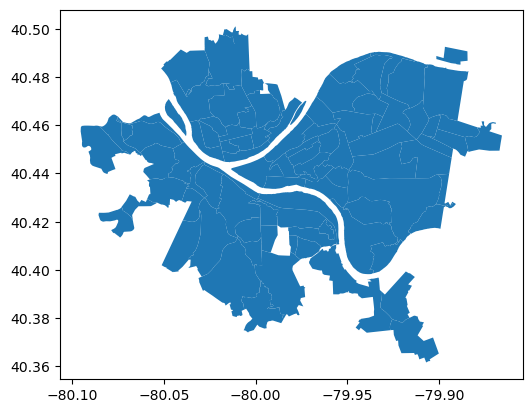

In [ ]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
#neighborhoods.head(10)
neighborhoods.plot()

I changed the names of the neighborhoods in the social services dataset. Some of the names in the dataset didn't match up with the names in the shapefile (for example, Downtown being called the Central Business District) and thus wouldn't be mapped.

In [ ]:
latitude = social['latitude']
longitude = social['longitude']
test = social['neighborhood']
index = 0
while index < social['neighborhood'].count():
    townName = fpsnippets.geo_to_neighborhood(float(latitude[index]), float(longitude[index]))
    if townName != 'None':
        social.loc[social['_id'] == index + 1, "neighborhood"] = townName
    index = index + 1

Here, I'm manually replacing the names of some of the data because they didn't have entries for latitude, longitude, or an address I could use.

In [ ]:
social = social.replace(["Downtown", "Uptown"], ["Central Business District", "Bluff"])
servicesNeighborhoods = social.groupby("neighborhood").count()
#print(servicesNeighborhoods)

,hood,_id,geometry
70,Marshall-Shadeland,1.0,"MULTIPOLYGON (((-80.02568 40.48276, -80.02498 ..."
71,Lincoln Place,NaN,"POLYGON ((-79.91046 40.37847, -79.91042 40.378..."
72,Overbrook,NaN,"POLYGON ((-79.99633 40.39458, -79.9963 40.3944..."
73,Homewood South,2.0,"POLYGON ((-79.88666 40.45521, -79.88651 40.455..."
74,Homewood North,NaN,"POLYGON ((-79.89446 40.46255, -79.89446 40.462..."
75,Homewood West,NaN,"POLYGON ((-79.90226 40.45563, -79.90227 40.455..."
76,Oakwood,NaN,"POLYGON ((-80.06442 40.42875, -80.06322 40.427..."
77,East Liberty,7.0,"POLYGON ((-79.91581 40.46088, -79.9158 40.4608..."
78,East Carnegie,NaN,"POLYGON ((-80.07255 40.42533, -80.07245 40.424..."
79,New Homestead,NaN,"POLYGON ((-79.91815 40.39936, -79.91621 40.398..."


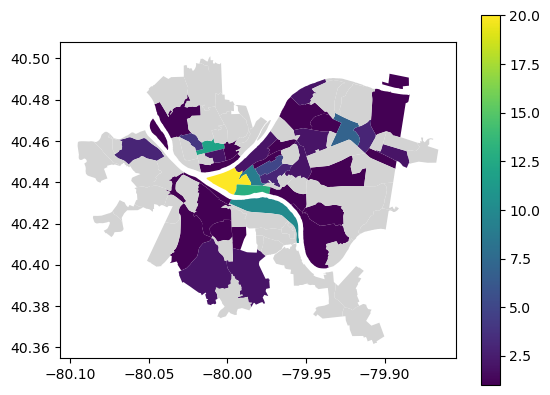

In [ ]:
socialMap = neighborhoods.merge(servicesNeighborhoods, how = "left", left_on = "hood", right_on = "neighborhood")
socialMap.plot(column="_id", legend = True, missing_kwds = {'color':'lightgrey'})
socialMap[['hood', '_id', 'geometry']].tail(20)

In this color coded map, it is clear that, in terms of numbers alone, the Central Business District has the most social services. Next, I made bar graphs representing the number of services in each neighborhood.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89]),
 [Text(0, 0, 'Central Oakland'),
  Text(1, 0, 'North Oakland'),
  Text(2, 0, 'West Oakland'),
  Text(3, 0, 'Crawford-Roberts'),
  Text(4, 0, 'Strip District'),
  Text(5, 0, 'Central Business District'),
  Text(6, 0, 'Spring Hill-City View'),
  Text(7, 0, 'Perry South'),
  Text(8, 0, 'Summer Hill'),
  Text(9, 0, 'Northview Heights'),
  Text(10, 0, 'Westwood'),
  Text(11, 0, 'Beltzhoover'),
  Text(12, 0, 'Central Lawrenceville'),
  Text(13, 0, 'South Side Flats'),
  Text(14, 0, 'Allentown'),
  Text(15, 0, 'South Side Slopes'),
  Text(16, 0, 'Bluff'),
  Text(17, 0, 'Fineview'),
  Text(1

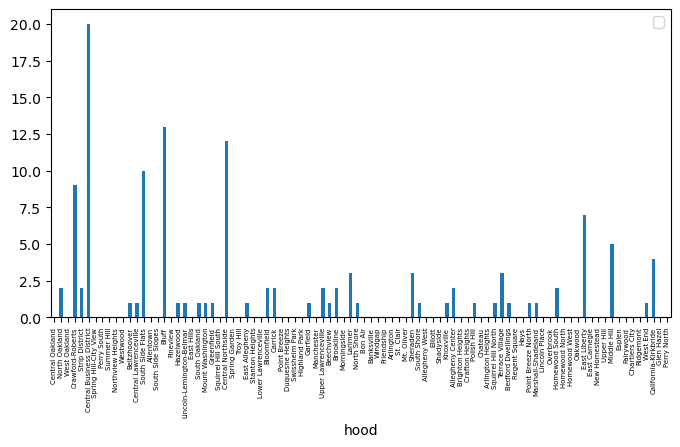

In [ ]:
socialMap.plot.bar(x = "hood", y = "_id", figsize=(8,4))
plt.xticks(size = 5)

A couple of the names, like the Central Business District, is listed as "Central Business District (Downtown)", which prevents it from merging correctly with other data and providing a population. Without this data, the neighborhood is eliminated completely from the rest of the analysis since it only returns NaN. So, I replaced the names with the ones they had in the dataframe I was merging the population data with.

In [ ]:
pop = pop.replace(["Arlington - Arlington Heights (Combined)", "Central Business District (Downtown)"], ["Arlington Heights", "Central Business District"])
population = pop[["Neighborhood", "2020_Total_Population"]]
#print(population['Neighborhood'].head(20))

In [ ]:
socialMap2 = socialMap.merge(population, how = 'left', left_on = 'hood', right_on = 'Neighborhood')
socialMap2['_id'] = socialMap2['_id'].fillna(0)

Calculating the service per person and normalizing the result over a range of 1-100. This gives us a standardized amount of points to add up in our final analysis.

In [ ]:
#normalize data
socialMap2['servicePerPerson'] = socialMap2['_id']/socialMap2['2020_Total_Population']

Normalizing with z score:

In [2]:
socialMean = socialMap2['servicePerPerson'].mean()
socialStDev = socialMap2['servicePerPerson'].std()
socialMap2['zScore'] = (socialMap2['servicePerPerson'] - socialMean)/socialStDev
socialMap2['normalizedZ'] = 100 / (1 + np.exp(-socialMap2['zScore']))
#top 10
socialMap2.sort_values(by = 'normalizedZ', ascending = False, inplace = True)
socialMap2.iloc[0:10].plot(kind = 'bar', x = "hood", y = "normalizedZ", figsize=(8,4))
print(socialMap2[['hood', 'normalizedZ']].head())

#bottom 10
socialMap2.sort_values(by = 'normalizedZ', ascending = True, inplace = True)
socialMap2.iloc[0:10].plot(kind = 'bar', x = "hood", y = "normalizedZ", figsize=(8,4))

NameError: name 'socialMap2' is not defined

# Conclusion

Based on the data, the best neightborhoods in terms of number of social services over a population, the best 3 neighborhoods are South Shore, California-Kirkbride, and West End. In comparison to my favorite neighborhood, the results are different. My favorite Pittsburgh neighborhood is Shadyside because of all of the specialty shops in the neighborhood. On the other hand, the worst Pittsburgh neighborhoods based in terms of social services include those that don't have any social services in them. There are many neighborhoods in Pittsburgh that don't have any and therefore are not represented in the graph even though they rank the same.

# Parks

In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


df = pd.read_csv('Data/parks_dataset.csv')

df.head()

,_id,id,name,type,maintenance_responsibility,image,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,1,2111959181,Able Long Park,Park,Parks - Southern,https://tools.wprdc.org/images/pittsburgh/park...,Beechview,4,19,42003192000,5,19,6,4-28,40.408118,-80.028197
1,2,1109513049,Albert Turk Graham Park,Park,Parks - Schenley,https://tools.wprdc.org/images/pittsburgh/park...,Crawford-Roberts,6,3,42003030500,3,3,2,2-1,40.440507,-79.984018
2,3,1544096765,Alcoa Park,Park,Parks - Northern,NaN,North Shore,1,22,42003563200,6,22,1,1-20,40.447481,-80.001017
3,4,1212681573,Allegheny Commons,Park,Parks - Northern,NaN,Allegheny Center,1,22,42003562700,1,22,1,1-7,40.453126,-80.009158
4,5,954863286,Allegheny Landing Park,Park,Parks - Northern,NaN,North Shore,1,22,42003563200,6,22,1,1-20,40.447184,-80.002907


In [10]:
df_neighborhood = df.groupby('neighborhood').agg(
    total_parks=('name', 'count'))

df_neighborhood.reset_index(inplace=True)
df_neighborhood.sort_values('total_parks', ascending=False, inplace=True)
df_neighborhood

,neighborhood,total_parks
22,East Liberty,12
13,Central Business District,10
5,Beechview,8
50,Point Breeze,7
57,South Side Slopes,7
...,...,...
34,Homewood West,1
47,Oakwood,1
41,Middle Hill,1
45,North Oakland,1


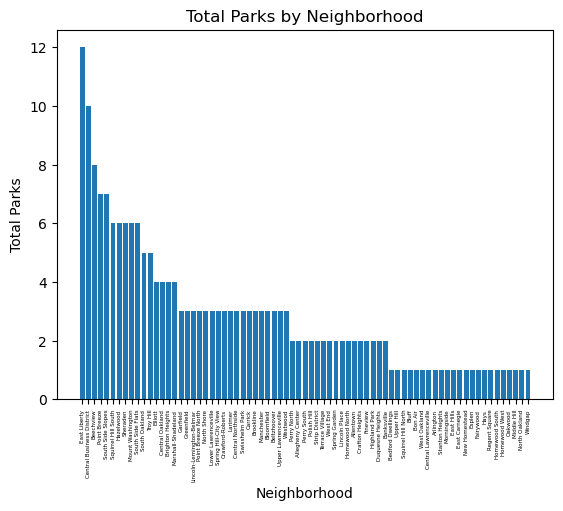

In [11]:
neighborhoods = df_neighborhood['neighborhood']
total_parks = df_neighborhood['total_parks'].values

plt.bar(neighborhoods, total_parks)
plt.title('Total Parks by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Total Parks')
plt.xticks(rotation=90, fontsize = 4)
plt.show()

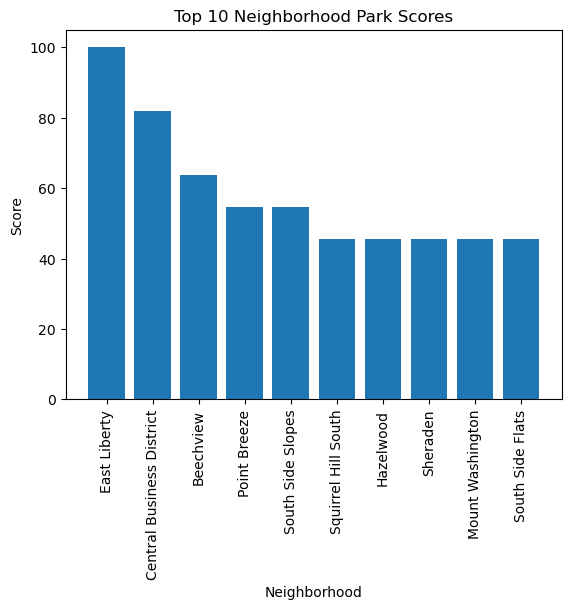

In [25]:
df_neighborhood['normalized'] = (df_neighborhood['total_parks'] - df_neighborhood['total_parks'].min()) / (df_neighborhood['total_parks'].max() - df_neighborhood['total_parks'].min())
df_neighborhood['normalized'] = df_neighborhood['normalized'] * 100
df_neighborhood.sort_values('normalized', ascending=False, inplace=True)
df_neighborhood.head()

plt.bar(neighborhoods[:10], df_neighborhood['normalized'][:10])
plt.title('Top 10 Neighborhood Park Scores')
plt.xlabel('Neighborhood')
plt.ylabel('Score')
plt.xticks(rotation=90, fontsize = 10)
plt.show()
plt.close()

In [30]:
df_neighborhood.sort_values('normalized', ascending=True, inplace=True)
df_neighborhood.head(10)


,neighborhood,total_parks,normalized
72,Windgap,1,0.0
14,Central Lawrenceville,1,0.0
9,Bon Air,1,0.0
62,Stanton Heights,1,0.0
8,Bluff,1,0.0
42,Morningside,1,0.0
2,Arlington,1,0.0
70,West Oakland,1,0.0
67,Upper Hill,1,0.0
4,Bedford Dwellings,1,0.0


Given the data, East Liberty, Central Business District and Beechview are the top neighborhoods for parks. I would personally agree that East Liberty is a nice neighborhood as there are many things to do. The list of worst neighborhoods for is probably not amazing. It doesn't take into account the land size. However, for all intents and purposes pop/parksstill seems to be an alright metric.

# Combining the Data

Now we're merging the data on the neighborhoods and adding up their scores. The neighborhoods with the highest totals are the "best", while the ones with the lowest scores are the "worst" based on this metric.

In [ ]:
#merge scores and neighborhoods
schoolScore = merged_df[['Neighborhood', 'Normalized Score']]
serviceScore = socialMap2[['hood', 'zScore']]
parkScore = df_neighborhood[['neighborhood', 'normalized']]

merge1 = schoolScore.merge(serviceScore, how = 'left', left_on = 'Neighborhood', right_on = 'hood')
mergeFinal = merge1.merge(parkScore, how = 'left', left_on = "Neighborhood", right_on = 'neighborhood')

# filling in any null values
mergeFinal['Normalized Score'] = mergeFinal['Normalized Score'].fillna(0)
mergeFinal['zScore'] = mergeFinal['zScore'].fillna(0)
mergeFinal['normalized'] = mergeFinal['normalized'].fillna(0)
print(mergeFinal)

#adding up the totals
mergeFinal['finalScore'] = mergeFinal['Normalized Score'] + mergeFinal['zScore'] + mergeFinal['normalized']

                 Neighborhood  Normalized Score                       hood  \
0   Central Business District         57.303965  Central Business District   
1                   Brookline         39.103889                  Brookline   
2                  Manchester         83.094343                 Manchester   
3         Squirrel Hill South         34.643297        Squirrel Hill South   
4                     Carrick         38.498667                    Carrick   
5                   Beechview         42.832115                  Beechview   
6            Allegheny Center         93.700769           Allegheny Center   
7              Homewood South         63.715631             Homewood South   
8                Point Breeze         41.941872               Point Breeze   
9                East Liberty         39.811856               East Liberty   
10                  Troy Hill         58.398139                  Troy Hill   
11                    Larimer         78.158348                 

These are the top 5 neighborhoods' scores and a graph of the top 10 neighborhoods.

In [ ]:
mergeFinal.sort_values('finalScore', ascending = False, inplace = True)
#print(mergeFinal)
mergeFinal[['hood', 'finalScore']].head()

,hood,finalScore
9,East Liberty,139.865056
0,Central Business District,139.839151
5,Beechview,106.258352
6,Allegheny Center,102.918110
2,Manchester,101.031359


<Axes: xlabel='hood'>

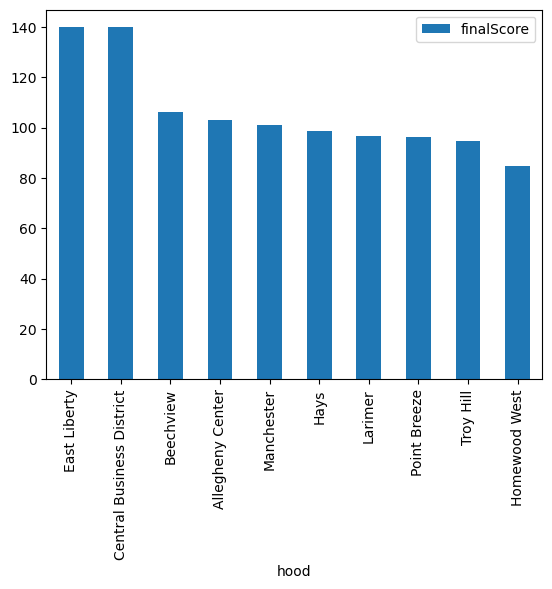

In [ ]:
mergeFinal.iloc[0:10].plot(kind = 'bar', x = 'hood', y = 'finalScore')

<Axes: xlabel='hood'>

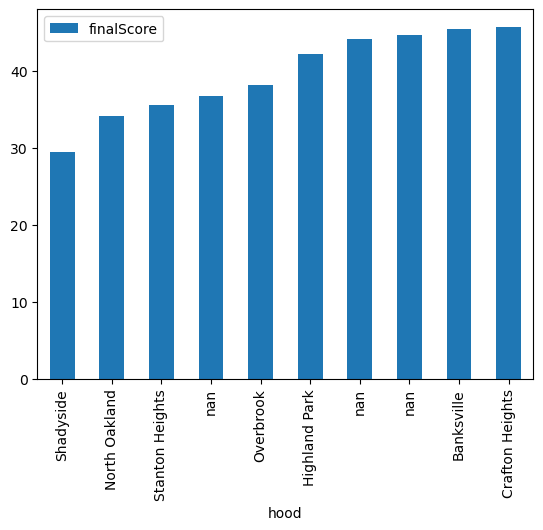

In [ ]:
mergeFinal.sort_values('finalScore', ascending = True, inplace = True)
mergeFinal.iloc[0:10].plot(kind = 'bar', x = 'hood', y = 'finalScore')

In [ ]:
mergeFinal[['hood', 'finalScore']].head()

,hood,finalScore
26,Shadyside,29.453171
12,North Oakland,34.102739
34,Stanton Heights,35.589475
42,NaN,36.688806
18,Overbrook,38.071444


From the data, the top three neighborhoods are East Liberty, Central Business District, and Beechview. The worst neighborhoods are Shadyside, North Oakland, and Stanton Heights. This result was different from our personal favorite neighborhood. All three of us named Shadyside as the best neighborhood, but it actually ranked worst in terms of social services.